In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scanpy.external as sce
import scipy as sp
import pandas as pd
import numpy as np
import os
import warnings
from Utils import *

warnings.filterwarnings('ignore')
sc.settings.verbosity = 0

In [3]:
# Setting up R dependencies
import anndata2ri
import rpy2
from rpy2.robjects import r
import random

anndata2ri.activate()

%load_ext rpy2.ipython

During startup - Warning message:
Setting LC_CTYPE failed, using "C" 


## QC

In [123]:
def filtering_reads(adata, verbose = True):
    from scipy.stats import median_abs_deviation
    def is_outlier(adata, metric: str, nmads: int):
        M = adata.obs[metric]
        outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
            np.median(M) + nmads * median_abs_deviation(M) < M
        )
        return outlier
    adata = adata.copy()
    adata.var_names_make_unique()
    raw_varinfo = adata.var_keys()
    raw_obsinfo = adata.obs_keys()
    
    # mitochondrial genes
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    # ribosomal genes
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    # hemoglobin genes.
    adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

    sc.pp.calculate_qc_metrics(
        adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
    )

    adata.obs["outlier"] = (
        is_outlier(adata, "log1p_total_counts", 10)
        | is_outlier(adata, "log1p_n_genes_by_counts", 10)
        | is_outlier(adata, "pct_counts_in_top_20_genes", 10)
    )
    adata.obs["mt_outlier"] = (adata.obs["pct_counts_mt"] > 20
    )
    
    raw_nobs = adata.n_obs
    adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()
    
    if verbose:
        print(f"Total number of cells: {raw_nobs}")
        print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")
    
    qc_varkeys = list(set(adata.var_keys()) - set(raw_varinfo))
    qc_obskeys = list(set(adata.obs_keys()) - set(raw_obsinfo))
    
    adata.uns['qc'] = {
        'obs': adata.obs[qc_obskeys],
        'var': adata.var[qc_varkeys]
    }
    
    adata.obs = adata.obs[raw_obsinfo]
    adata.var = adata.var[raw_varinfo]
    
    return adata

In [124]:
filepath = '/share/home/biopharm/wqr/AFPGC/sc/data'
subfolders = ['LM_pos1', 'LM_pos2', 'LM_neg']

tempadatalist = []
for subfolder in subfolders:
    tempadata = sc.read_10x_mtx(os.path.join(filepath, subfolder, 'filtered_feature_bc_matrix'), var_names='gene_symbols', cache=True)
    tempadata = filtering_reads(tempadata) 
    tempadatalist.append(tempadata)

adata = sc.concat(tempadatalist, join='outer', label='group', keys=subfolders, index_unique='-')
sc.pp.filter_genes(adata, min_cells=3)
adata.raw = adata.copy()
adata.var_names_make_unique()

## Normalization

In [129]:
sc.pp.highly_variable_genes(adata,flavor='seurat_v3',n_top_genes=2000)
sc.pp.normalize_total(adata,target_sum=1e5)
sc.pp.log1p(adata)
if 'log1p' not in adata.uns.keys():
    adata.uns['log1p'] = {}
adata.uns['log1p']['base'] = np.e 
adata.layers['log'] = adata.X.copy()
sc.pp.scale(adata)
adata.layers['counts'] = adata.raw.X.copy()
adata.layers['normalized'] = adata.X.copy()

## Dimensionality reduction & Clustering

In [4]:
adata =  sc.read_h5ad("/share/home/biopharm/wqr/AFPGC/sc/Results/github/all_leiden_merged.h5ad")

In [130]:
%%time
#sc.pp.highly_variable_genes(adata, layer="log")
sc.pp.pca(adata,use_highly_variable=False)
sce.pp.harmony_integrate(adata, key = 'group', max_iter_harmony = 15)

2024-04-22 03:52:12,432 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-04-22 03:52:22,945 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-04-22 03:52:23,154 - harmonypy - INFO - Iteration 1 of 15
2024-04-22 03:52:30,930 - harmonypy - INFO - Iteration 2 of 15
2024-04-22 03:52:39,464 - harmonypy - INFO - Iteration 3 of 15
2024-04-22 03:52:47,418 - harmonypy - INFO - Iteration 4 of 15
2024-04-22 03:52:56,087 - harmonypy - INFO - Iteration 5 of 15
2024-04-22 03:53:05,132 - harmonypy - INFO - Iteration 6 of 15
2024-04-22 03:53:13,439 - harmonypy - INFO - Iteration 7 of 15
2024-04-22 03:53:22,991 - harmonypy - INFO - Converged after 7 iterations


CPU times: user 24min 47s, sys: 29min 5s, total: 53min 52s
Wall time: 2min 18s


In [131]:
sc.pp.neighbors(adata, use_rep='X_pca_harmony')
sc.tl.umap(adata)

In [11]:
# Replace 'LM_pos1' and 'LM_pos2' with 'LM_pos' in the 'group' column of adata.obs
adata.obs['group'] = adata.obs['group'].replace({'LM_pos1': 'LM_pos', 'LM_pos2': 'LM_pos'})

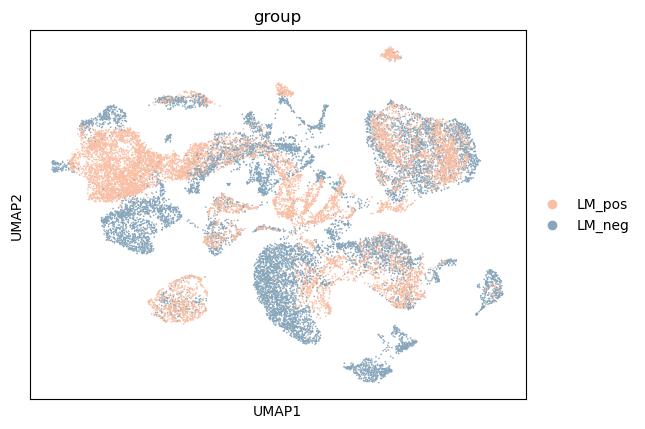

In [5]:
# Define a custom color palette for the groups
group_colors = {'LM_pos': '#f9bfa4', 'LM_neg': '#88a6bb'} 
adata.uns['group_colors'] = [group_colors[label] for label in adata.obs['group'].cat.categories]

# Plot the UMAP
sc.pl.umap(
    adata,
    color=['group'],
    ncols=3,
    vmin=-1.5,
    vmax=1.5,
    cmap="RdBu_r",
    save='group_umap.svg'
)

In [132]:
sc.tl.leiden(adata, key_added="leiden_res0_8", resolution=0.8)

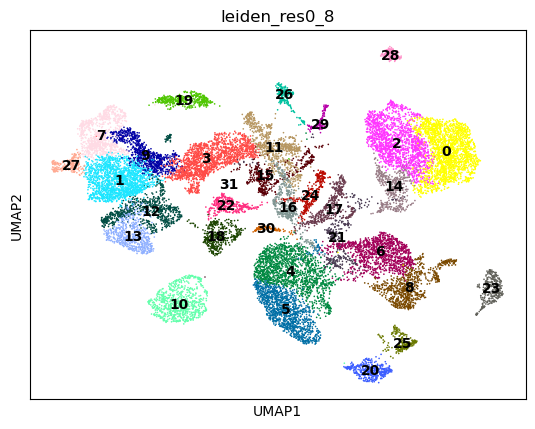

In [6]:
sc.pl.umap(adata, color=["leiden_res0_8"], legend_loc='on data',ncols=2)

## Annotation

### Cell Type Annotation

In [3]:
# New merging rules for cell types
merge_dict = {
    '0': 'CD8+ T',
    '1': 'Epithelial Cell',
    '2': 'CD4+ T',
    '3': 'Epithelial Cell',
    '4': 'Neutrophil',
    '5': 'Neutrophil',
    '6': 'Neutrophil',
    '7': 'Epithelial Cell',
    '8': 'Macrophage',
    '9': 'Epithelial Cell',
    '10': 'Endothelial Cell',
    '11': 'Epithelial Cell',
    '12': 'Epithelial Cell',
    '13': 'Epithelial Cell',
    '14': 'CD4+ T',
    '15': 'Epithelial Cell',
    '16': 'Epithelial Cell',
    '17': 'Epithelial Cell',
    '18': 'Fibroblast',
    '19': 'Epithelial Cell',
    '20': 'Plasma Cell',
    '21': 'Epithelial Cell',
    '22': 'Fibroblast',
    '23': 'B Cell',
    '24': 'Fibroblast',
    '25': 'Plasma Cell',
    '26': 'Epithelial Cell',
    '27': 'Epithelial Cell',
    '28': 'Epithelial Cell',
    '29': 'Epithelial Cell',
    '30': 'Mast Cell',
    '31': 'Epithelial Cell'
}

# Update adata.obs to reflect the new merging rules
data.obs['leiden_res0_8_merged3'] = adata.obs['leiden_res0_8'].map(merge_dict)
print(adata.obs[['leiden_res0_8', 'leiden_res0_8_merged3']])


                                   leiden_res0_8 leiden_res0_8_merged3
AAACCCACATGGGCAA-1-trans                      11       Epithelial Cell
AAACCCAGTGACAACG-1-trans                       3       Epithelial Cell
AAACCCAGTTCCGTTC-1-trans                      26       Epithelial Cell
AAACCCATCAAGGACG-1-trans                       1       Epithelial Cell
AAACCCATCCAAGGGA-1-trans                      18            Fibroblast
...                                          ...                   ...
TTTGTTGCAGTAGTGG-1-non_trans_zheyi            14                CD4+ T
TTTGTTGGTAACCAGG-1-non_trans_zheyi             4            Neutrophil
TTTGTTGGTGTGTGTT-1-non_trans_zheyi            17       Epithelial Cell
TTTGTTGTCACCGCTT-1-non_trans_zheyi             3       Epithelial Cell
TTTGTTGTCATAAGGA-1-non_trans_zheyi             2                CD4+ T

[21400 rows x 2 columns]


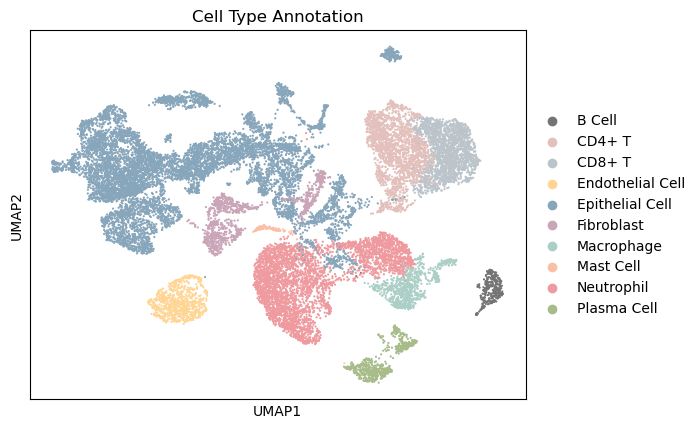

In [7]:
# Mapping cell types to specific colors
cell_type_colors = {
    'Mast Cell': '#fabfa4',
    'B Cell': '#747474',
    'Plasma Cell': '#A8BC8A',
    'Endothelial Cell': '#ffd594',
    'Macrophage': '#abcfc6',
    'Fibroblast': '#c9a5b7', 
    'CD8+ T': '#bbc4ca',
    'CD4+ T': '#e3c0bb',
    'Neutrophil': '#EE9A9F',
    'Epithelial Cell': '#88a6bb' 
}

# Get the unique cell types and sort them
unique_cell_types = adata.obs['leiden_res0_8_merged3'].unique()
unique_cell_types_sorted = sorted(unique_cell_types)
# Create a color palette based on the sorted cell types
palette = [cell_type_colors[cell_type] for cell_type in unique_cell_types_sorted]

# Define the save path and file prefix
save_path = '/share/home/biopharm/wqr/AFPGC/sc/Results/github'
file_name_prefix = 'annotation'
os.makedirs(save_path, exist_ok=True)
sc.settings.figdir = save_path

# Plot the UMAP with cell type annotations
sc.pl.umap(
    adata,
    color='leiden_res0_8_merged3', 
    title='Cell Type Annotation',
    size=10, 
    palette=palette,  
    save="cell_type_umap.svg" 
)


In [ ]:
adata.write('/share/home/biopharm/wqr/AFPGC/sc/Results/github/all_leiden_merged.h5ad')

### Immune Cell Annotation

                         leiden_res0_8 leiden_res0_8_merged3  \
AAACCCACATGGGCAA-1-trans            11       Epithelial Cell   
AAACCCAGTGACAACG-1-trans             3       Epithelial Cell   
AAACCCAGTTCCGTTC-1-trans            26       Epithelial Cell   
AAACCCATCAAGGACG-1-trans             1       Epithelial Cell   
AAACCCATCCAAGGGA-1-trans            18            Fibroblast   

                         cell_type_category  
AAACCCACATGGGCAA-1-trans   Non-immune Cells  
AAACCCAGTGACAACG-1-trans   Non-immune Cells  
AAACCCAGTTCCGTTC-1-trans   Non-immune Cells  
AAACCCATCAAGGACG-1-trans   Non-immune Cells  
AAACCCATCCAAGGGA-1-trans   Non-immune Cells  


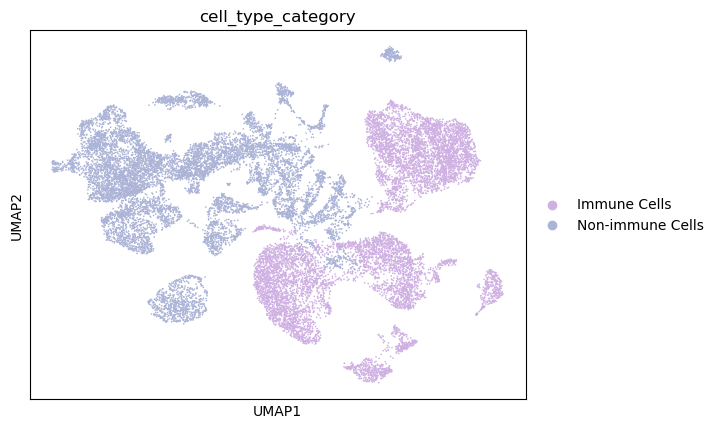

In [8]:
# Define the new merging rule
further_merge_dict = {
    'CD8+ T': 'Immune Cells',
    'CD4+ T': 'Immune Cells',
    'Neutrophil': 'Immune Cells',
    'Macrophage': 'Immune Cells',
    'Plasma Cell': 'Immune Cells',
    'B Cell': 'Immune Cells',
    'Mast Cell': 'Immune Cells',
    'Endothelial Cell': 'Non-immune Cells',
    'Epithelial Cell': 'Non-immune Cells',
    'Fibroblast': 'Non-immune Cells'
}


# Define color dictionary
custom_colors = {
    'Immune Cells': '#cfb0e3',
    'Non-immune Cells': '#ABB3D7'
}

save_path = '/share/home/biopharm/wqr/AFPGC/sc/Results/github'
sc.settings.figdir = save_path

adata.obs['cell_type_category'] = adata.obs['leiden_res0_8_merged3'].map(further_merge_dict)
print(adata.obs[['leiden_res0_8', 'leiden_res0_8_merged3', 'cell_type_category']].head())

sc.pl.umap(
    adata,
    color='cell_type_category',  
    palette=custom_colors, 
    save='immune_type_umap.svg'
)

### Neutrophil Annotation

                         leiden_res0_8 leiden_res0_8_merged3  \
AAACCCACATGGGCAA-1-trans            11       Epithelial Cell   
AAACCCAGTGACAACG-1-trans             3       Epithelial Cell   
AAACCCAGTTCCGTTC-1-trans            26       Epithelial Cell   
AAACCCATCAAGGACG-1-trans             1       Epithelial Cell   
AAACCCATCCAAGGGA-1-trans            18            Fibroblast   

                         cell_type_highlight  
AAACCCACATGGGCAA-1-trans               Other  
AAACCCAGTGACAACG-1-trans               Other  
AAACCCAGTTCCGTTC-1-trans               Other  
AAACCCATCAAGGACG-1-trans               Other  
AAACCCATCCAAGGGA-1-trans               Other  


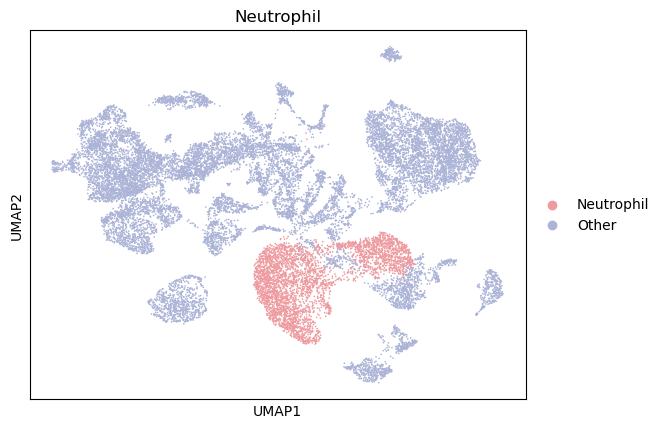

In [9]:
# Define the new merging rule
further_merge_dict = {
    'CD8+ T': 'Other',
    'CD4+ T': 'Other',
    'Neutrophil': 'Neutrophil',
    'Macrophage': 'Other',
    'Plasma Cell': 'Other',
    'B Cell': 'Other',
    'Mast Cell': 'Other',
    'Endothelial Cell': 'Other',
    'Epithelial Cell': 'Other',
    'Fibroblast': 'Other'
}

custom_colors = {
    'Neutrophil': '#EE9A9F',
    'Other': '#ABB3D7' 
}

save_path = '/share/home/biopharm/wqr/AFPGC/sc/Results/github'
sc.settings.figdir = save_path

adata.obs['cell_type_highlight'] = adata.obs['leiden_res0_8_merged3'].map(further_merge_dict)
print(adata.obs[['leiden_res0_8', 'leiden_res0_8_merged3', 'cell_type_highlight']].head())

sc.pl.umap(
    adata,
    color='cell_type_highlight', 
    palette=custom_colors,  
    title='Neutrophil',
    save='neutrophil_umap.svg'
)

In [ ]:
# Extract and save neutrophil
neutrophil_indices = adata.obs.index[adata.obs['leiden_res0_8_merged'] == 'Neutrophil']
neutrophil_adata = adata[neutrophil_indices]
neutrophil_adata.write('/share/home/biopharm/wqr/AFPGC/sc/Results/github/neutrophil.h5ad')

### Cell Calculation for Each Type

In [30]:
group_cluster_counts = adata.obs.groupby(['leiden_res0_8_merged3', 'group']).size().unstack(fill_value=0)
group_totals = adata.obs['group'].value_counts()
group_proportions = group_cluster_counts.div(group_totals, axis=1)

cluster_group_summary = pd.concat([group_cluster_counts, group_proportions], axis=1, keys=['Count', 'Proportion'])
cluster_group_summary.columns = ['{}_{}'.format(col, stat) for stat in ['Count', 'Proportion'] for col in group_cluster_counts.columns]

output_path = '/share/home/biopharm/wqr/AFPGC/sc/Results/github/cluster_group_summary_leiden_res0_8_merged3.csv'
output_dir = os.path.dirname(output_path)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
cluster_group_summary.to_csv(output_path, sep='\t')

## DEG

In [3]:
adata = sc.read_h5ad('/share/home/biopharm/wqr/AFPGC/sc/Results/github/all_leiden_merged.h5ad')

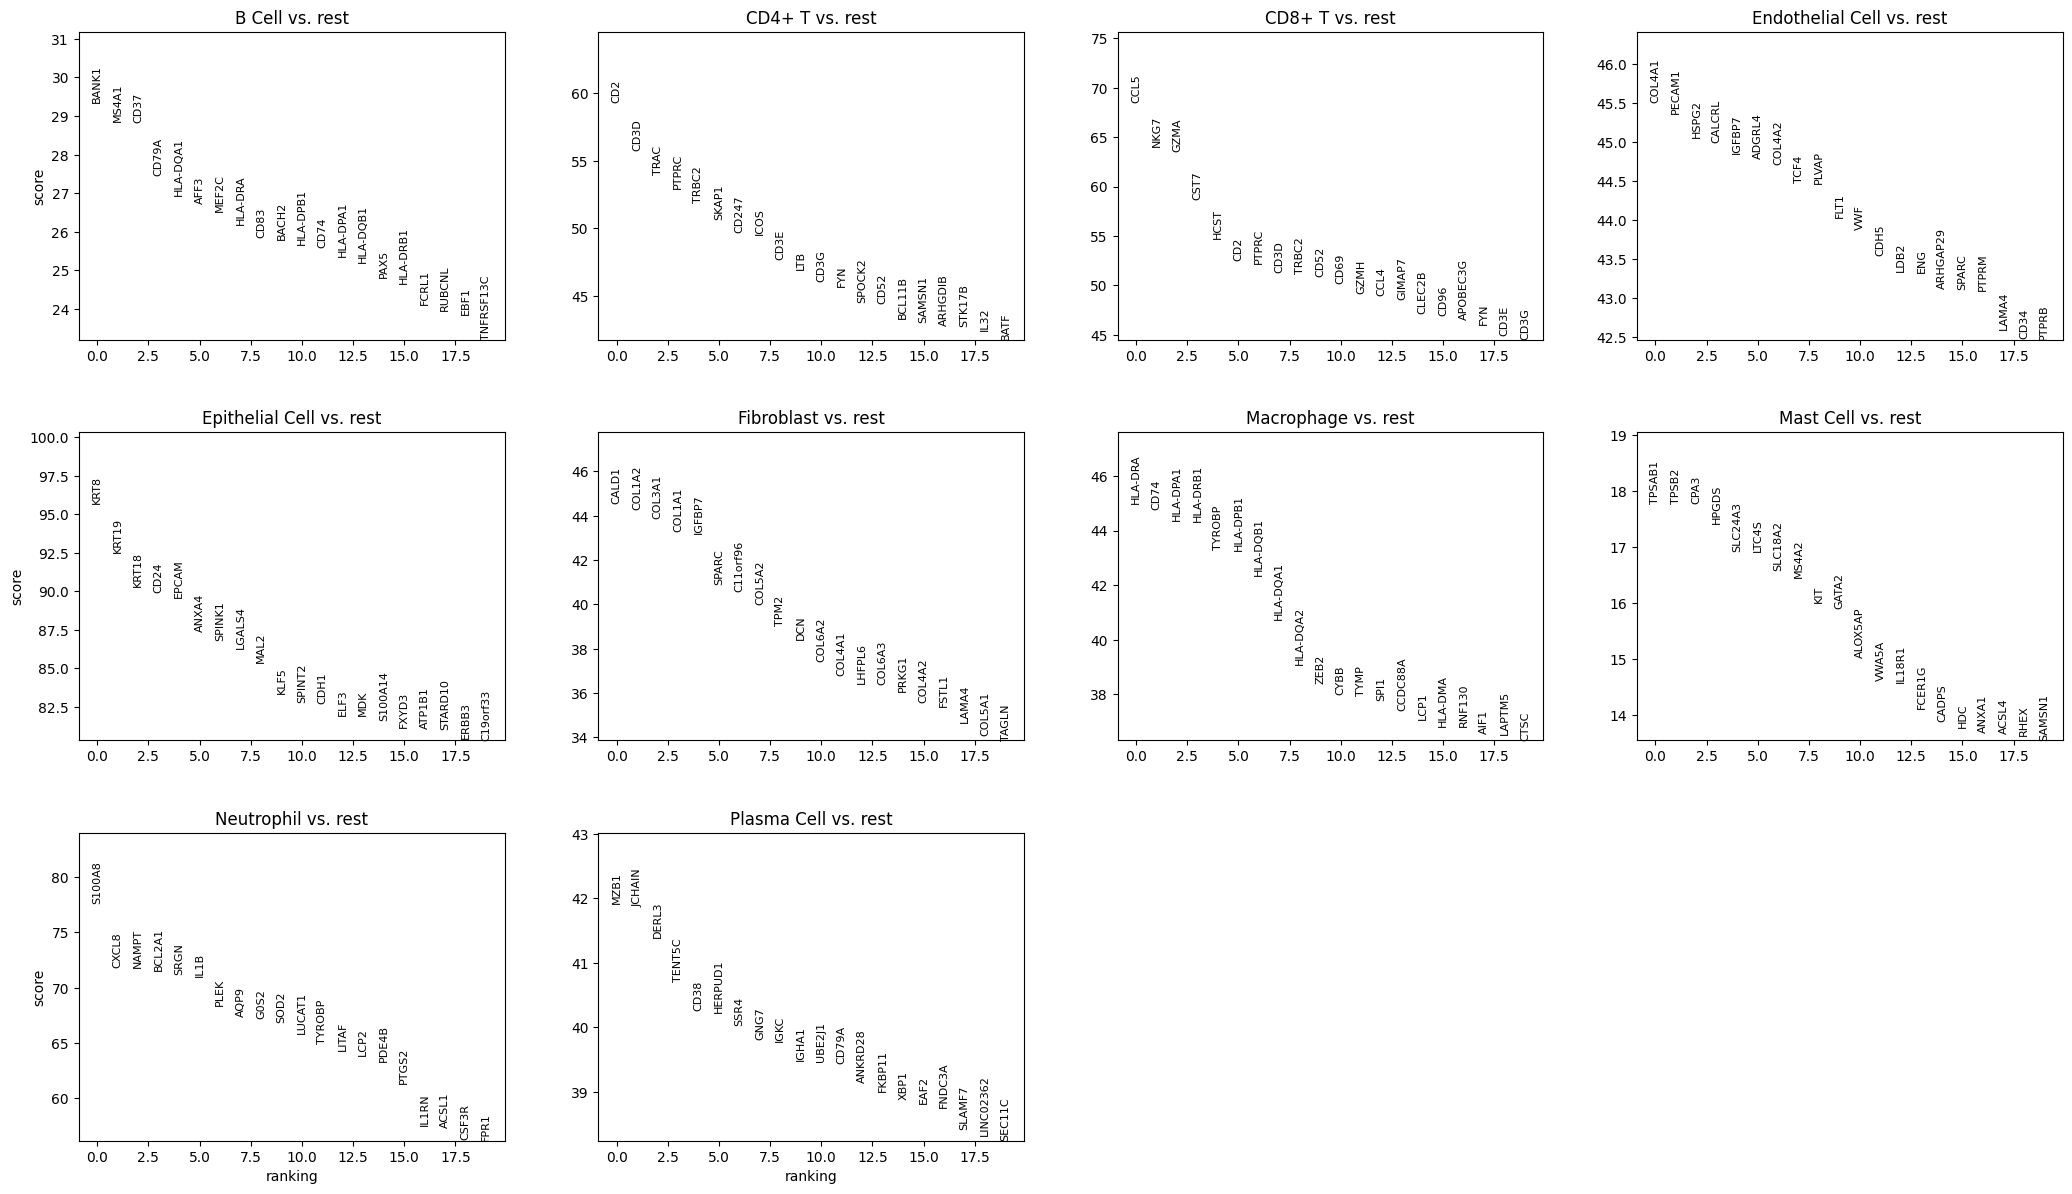

In [3]:
# Find marker genes
# Perform differential gene expression analysis on each cell type after clustering using the Wilcoxon test method, and visualize the top 20 differentially expressed genes.
# Compared to the t-test method, the Wilcoxon test is more suitable for differential expression analysis in small sample sizes and non-normally distributed data.
adata.uns['log1p']['base'] = np.e 
sc.tl.rank_genes_groups(adata, 'leiden_res0_8_merged3', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [6]:
# Extract differential expression results
diff_exp_results = adata.uns['rank_genes_groups']

all_results = []
groups = diff_exp_results['names'].dtype.names
for group in groups:
    names = diff_exp_results['names'][group]
    scores = diff_exp_results['scores'][group]
    group_results = pd.DataFrame({
        'names': names,
        'scores': scores
    })
    
    group_results['group'] = group
    all_results.append(group_results)

all_results_df = pd.concat(all_results, ignore_index=True)
all_results_df.to_csv('/share/home/biopharm/wqr/AFPGC/sc/Results/github/DEG_wilcoxon.csv', index=False)

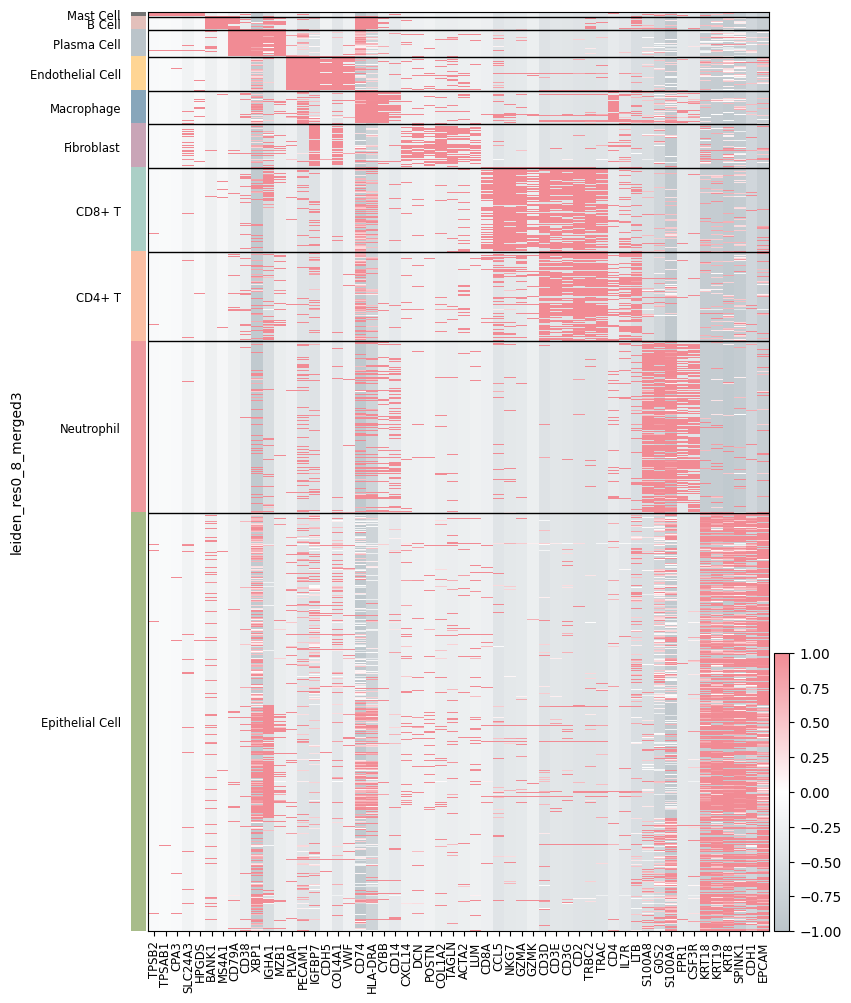

In [24]:
from matplotlib.colors import LinearSegmentedColormap

# Customize colors for high and low expression levels
high_expression = '#f18b94'
low_expression = '#bbc4ca'
custom_cmap = LinearSegmentedColormap.from_list(
    'custom_cmap', [low_expression, 'white', high_expression], N=256
)

# Define custom order for cell types
custom_order = [
    'Mast Cell', 'B Cell', 'Plasma Cell', 'Endothelial Cell', 'Macrophage', 'Fibroblast', 'CD8+ T', 'CD4+ T', 'Neutrophil', 'Epithelial Cell'
]
adata.obs['leiden_res0_8_merged3'] = pd.Categorical(
    adata.obs['leiden_res0_8_merged3'],
    categories=custom_order,
    ordered=True
)

# Define colors for each cell type
cell_type_colors = {
    'Mast Cell': '#fabfa4',
    'B Cell': '#747474',
    'Plasma Cell': '#A8BC8A',
    'Endothelial Cell': '#ffd594',
    'Macrophage': '#abcfc6',
    'Fibroblast': '#c9a5b7', 
    'CD8+ T': '#bbc4ca',
    'CD4+ T': '#e3c0bb',
    'Neutrophil': '#EE9A9F',
    'Epithelial Cell': '#88a6bb'
}

# Assign cell type colors
adata.uns['leiden_res0_8_merged3_colors'] = [cell_type_colors[ct] for ct in custom_order]

# Marker genes for each cell type
deg_df = pd.read_csv('/share/home/biopharm/wqr/AFPGC/sc/Results/github/DEG_selected.csv', header=None, names=['CellType', 'Gene'])
marker_genes = {}
for i, row in deg_df.iterrows():
    cell_type = row['CellType']
    gene = row['Gene']
    if cell_type not in marker_genes:
        marker_genes[cell_type] = []
    marker_genes[cell_type].append(gene)

genes_of_interest = []
for cell_type in custom_order:
    genes_of_interest.extend(marker_genes.get(cell_type, []))


# Plot the heatmap
sc.pl.rank_genes_groups_heatmap(
    adata,
    vmin=-1, vmax=1,
    layer='normalized',
    var_names=genes_of_interest, 
    groupby='leiden_res0_8_merged3',
    show_gene_labels=True,
    cmap=custom_cmap, 
    figsize=(8.5, 12),
    dendrogram=False,
    save='DEG_heatmap.svg'
)


## Reclustering

In [21]:
adata =  sc.read_h5ad("/share/home/biopharm/wqr/AFPGC/sc/Results/github/Neutrophil_leiden_3cluster.h5ad")

In [22]:
def filtering_reads_again(adata, verbose = True):
    from scipy.stats import median_abs_deviation
    def is_outlier(adata, metric: str, nmads: int):
        M = adata.obs[metric]
        outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
            np.median(M) + nmads * median_abs_deviation(M) < M
        )
        return outlier
    adata = adata.copy()
    adata.var_names_make_unique()
    raw_varinfo = adata.var_keys()
    raw_obsinfo = adata.obs_keys()
    
    # mitochondrial genes
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    # ribosomal genes
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    # hemoglobin genes.
    adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

    sc.pp.calculate_qc_metrics(
        adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
    )

    adata.obs["outlier"] = (
        is_outlier(adata, "log1p_total_counts", 6)
        | is_outlier(adata, "log1p_n_genes_by_counts", 6)
        | is_outlier(adata, "pct_counts_in_top_20_genes", 6)
    )
    adata.obs["mt_outlier"] = (adata.obs["pct_counts_mt"] > 13
    )
    
    raw_nobs = adata.n_obs
    adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()
    
    if verbose:
        print(f"Total number of cells: {raw_nobs}")
        print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")
    
    qc_varkeys = list(set(adata.var_keys()) - set(raw_varinfo))
    qc_obskeys = list(set(adata.obs_keys()) - set(raw_obsinfo))
    
    adata.uns['qc'] = {
        'obs': adata.obs[qc_obskeys],
        'var': adata.var[qc_varkeys]
    }
    
    adata.obs = adata.obs[raw_obsinfo]
    adata.var = adata.var[raw_varinfo]
    
    return adata

In [23]:
adata = filtering_reads_again(adata)

Total number of cells: 3379
Number of cells after filtering of low quality cells: 3352


In [14]:
%%time
# sc.pp.highly_variable_genes(adata, layer="log")
sc.pp.pca(adata,use_highly_variable=False)
sce.pp.harmony_integrate(adata, key = 'group', max_iter_harmony = 15,)

2024-11-11 11:40:53,586 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-11 11:40:59,203 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-11 11:40:59,271 - harmonypy - INFO - Iteration 1 of 15
2024-11-11 11:41:00,712 - harmonypy - INFO - Iteration 2 of 15
2024-11-11 11:41:02,099 - harmonypy - INFO - Iteration 3 of 15
2024-11-11 11:41:03,405 - harmonypy - INFO - Iteration 4 of 15
2024-11-11 11:41:04,714 - harmonypy - INFO - Iteration 5 of 15
2024-11-11 11:41:05,705 - harmonypy - INFO - Iteration 6 of 15
2024-11-11 11:41:06,986 - harmonypy - INFO - Iteration 7 of 15
2024-11-11 11:41:07,942 - harmonypy - INFO - Iteration 8 of 15
2024-11-11 11:41:08,781 - harmonypy - INFO - Iteration 9 of 15
2024-11-11 11:41:09,337 - harmonypy - INFO - Iteration 10 of 15
2024-11-11 11:41:10,037 - harmonypy - INFO - Iteration 11 of 15
2024-11-11 11:41:10,562 - harmonypy - INFO - Iteration 12 of 15
2024-11-11 11:41:11,228 - harmonypy - INFO - Converged after

CPU times: user 11min 38s, sys: 11min 51s, total: 23min 30s
Wall time: 30.8 s


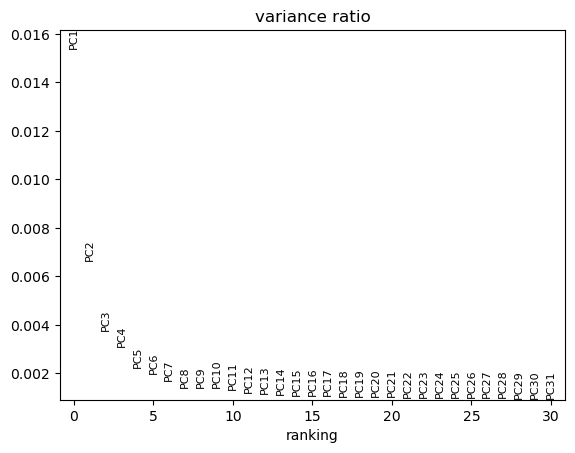

In [15]:
sc.pl.pca_variance_ratio(adata)

In [16]:
sc.pp.neighbors(adata, use_rep='X_pca_harmony',n_pcs=15 )
sc.tl.umap(adata)

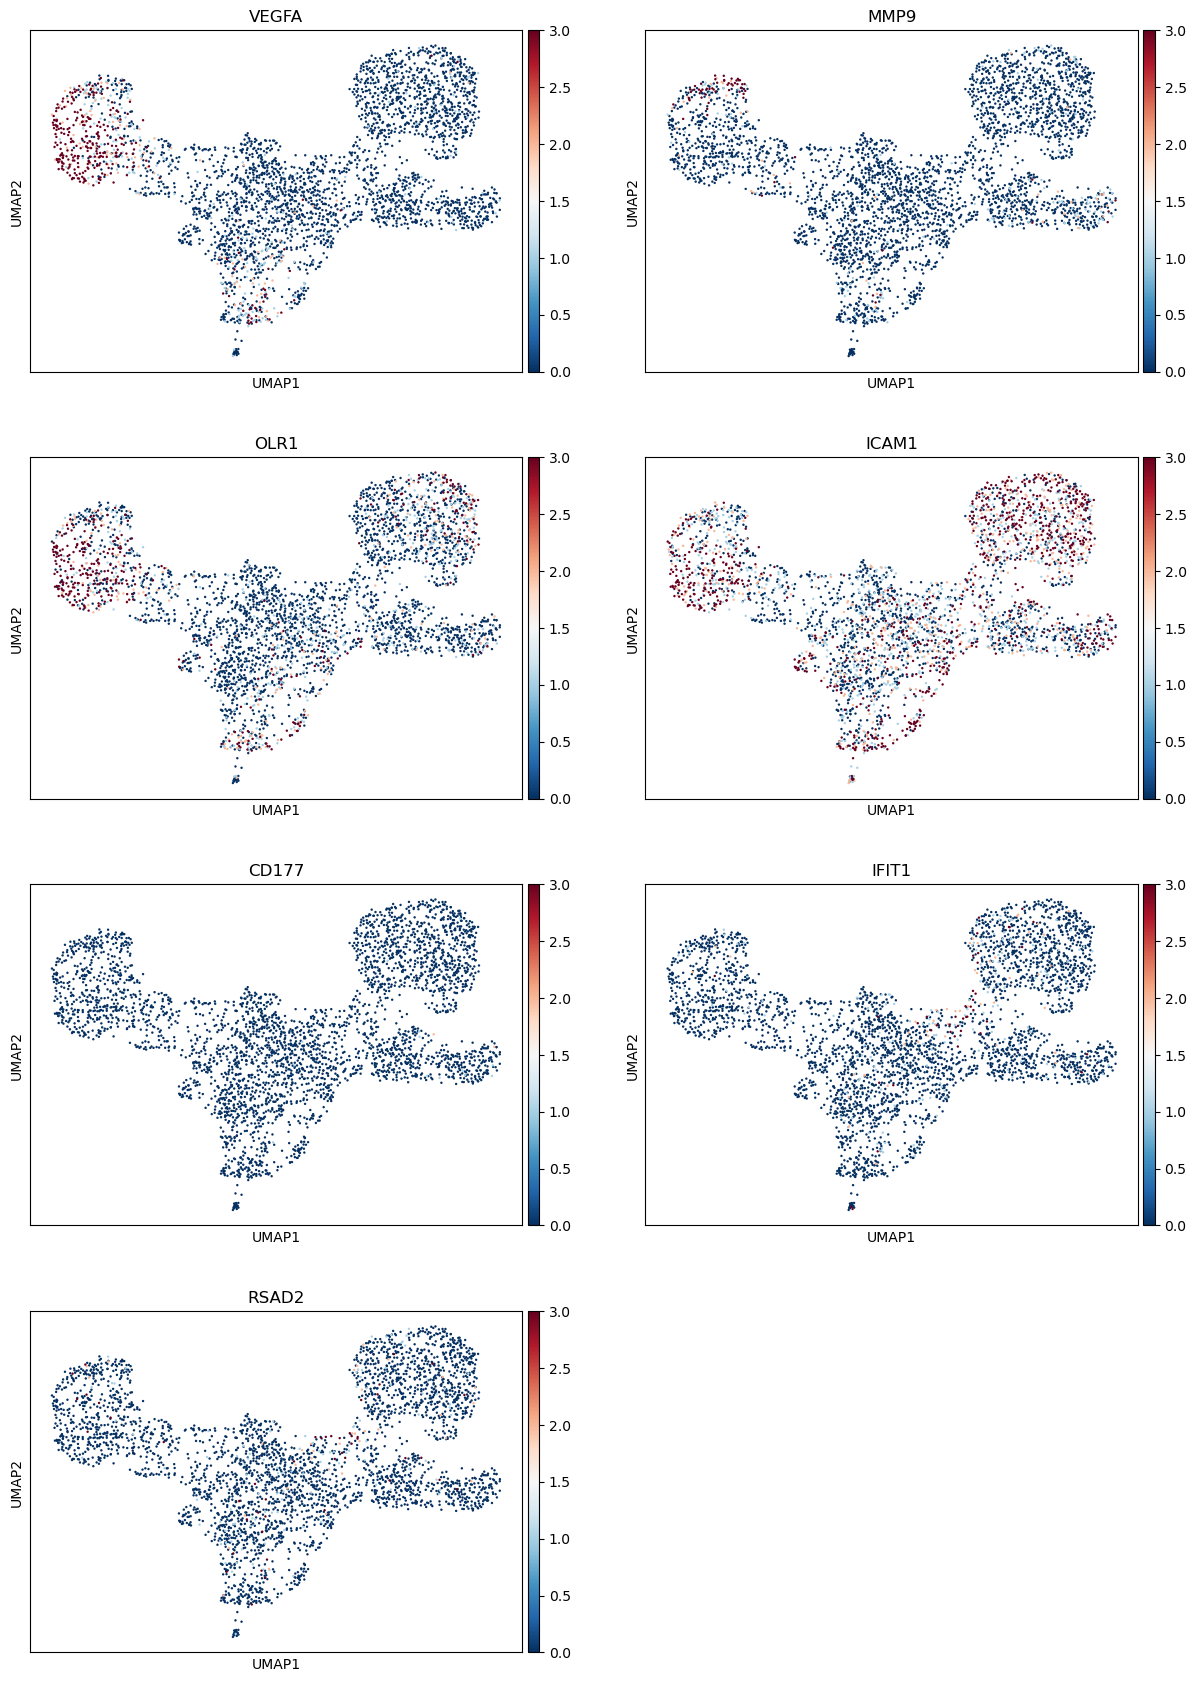

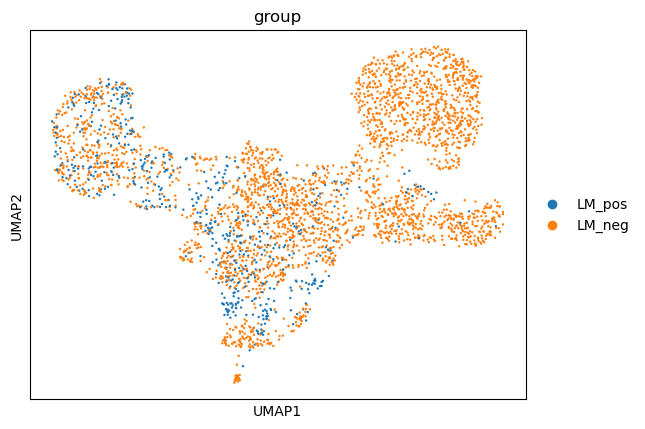

In [28]:
save_path = '/share/home/biopharm/wqr/AFPGC/sc/Results/github/Neutrophil'
os.makedirs(save_path, exist_ok=True)
sc.settings.figdir = save_path

#Plot the UMAP of different gene markers
sc.pl.umap(
    adata,color = ["VEGFA", "MMP9", "OLR1", "ICAM1", "CD177", "IFIT1", "RSAD2"],vmax =3,
    ncols = 2,  cmap = "RdBu_r", size = 12,
    save='neutrophil_subtype_marker.svg'
)
sc.pl.umap(adata, color=["group"], size = 12)

In [18]:
sc.tl.leiden(adata, key_added="leiden_res0_01", resolution=0.01)
sc.tl.leiden(adata, key_added="leiden_res0_05", resolution=0.05)
sc.tl.leiden(adata, key_added="leiden_res0_03", resolution=0.03)
sc.tl.leiden(adata, key_added="leiden_res0_1", resolution=0.1)

In [27]:
adata.write("/share/home/biopharm/wqr/AFPGC/sc/Results/github/Neutrophil_leiden_3cluster.h5ad")

In [30]:
adata.obs['leiden_merged'] = adata.obs['leiden_res0_05'].replace({'2': 'N2', '0': 'Non_N2','1':'Non_N2'})

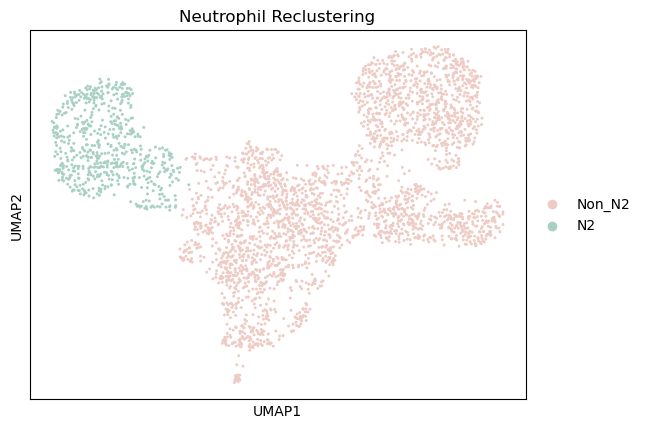

In [31]:
save_path = '/share/home/biopharm/wqr/AFPGC/sc/Results/github/Neutrophil'
os.makedirs(save_path, exist_ok=True)
sc.settings.figdir = save_path

color_dict = {
    'N2': '#a8d1c4',
    'Non_N2': '#eecbc4'
}

# Plot the UMAP of neutrophil subtypes
sc.pl.umap(
    adata,
    color='leiden_merged',
    size=18,
    title='Neutrophil Reclustering',
    palette=color_dict,
    save='Neutrophil_Reclustering.svg'
)

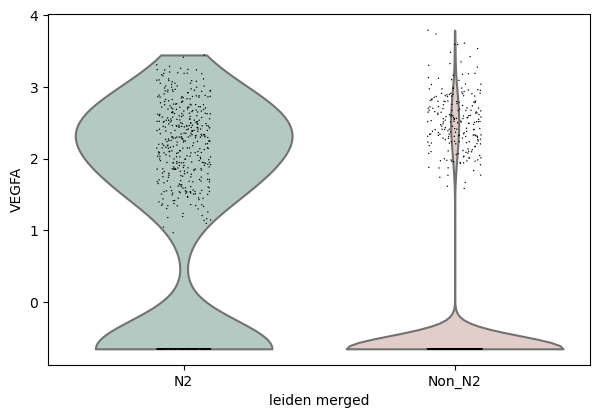

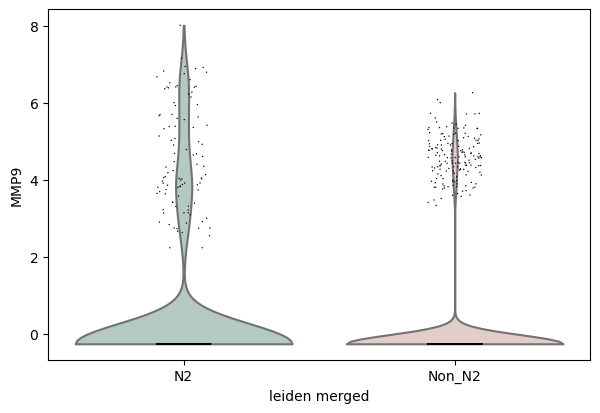

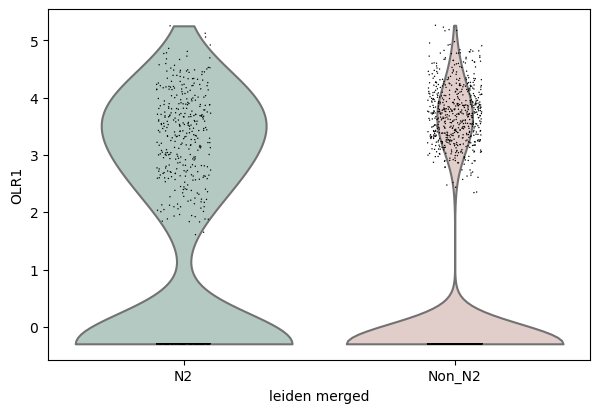

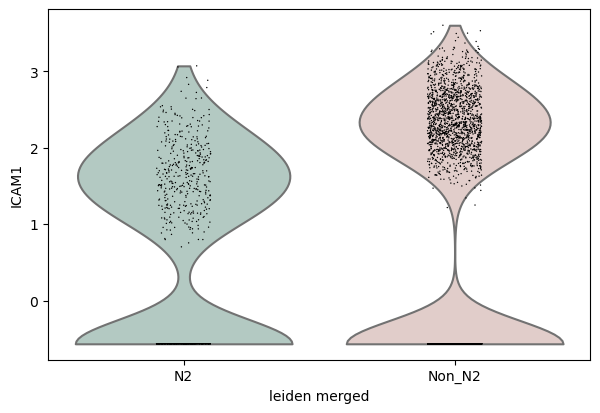

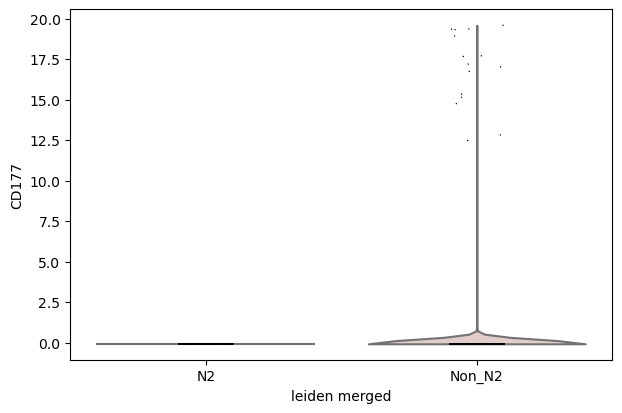

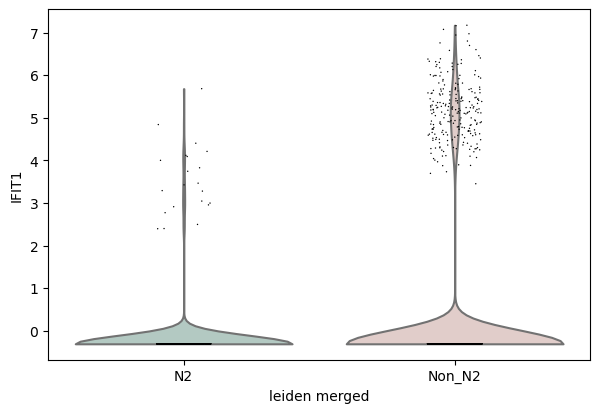

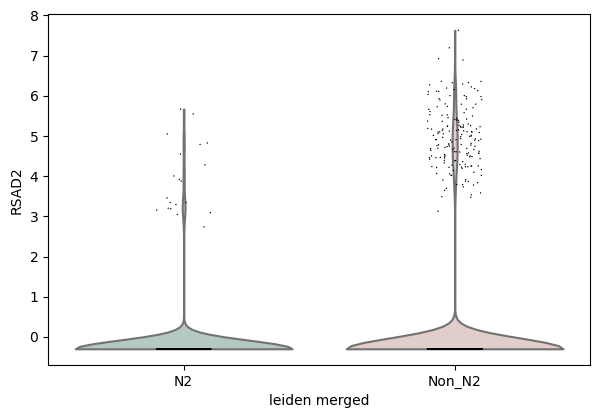

In [33]:
categories_order = ['N2', 'Non_N2']
palette = ['#AFCDC3', '#E5CAC6']

gene_markers = ["VEGFA", "MMP9", "OLR1", "ICAM1", "CD177", "IFIT1", "RSAD2"]

#Generate violin plots
for gene in gene_markers:
    sc.pl.violin(
        adata,
        keys=gene,
        groupby='leiden_merged',
        layer='normalized',
        use_raw=False,
        order=categories_order,
        palette=palette,
        save=f'{gene}_violin.svg'
    )

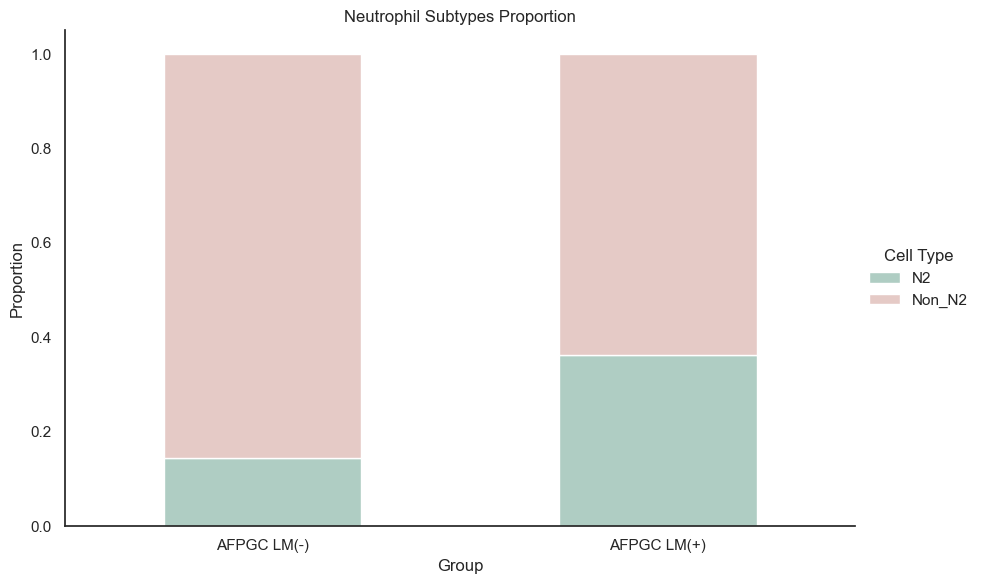

In [34]:
# Calculate proportions and plot
cell_counts = adata.obs.groupby(['group', 'leiden_merged']).size().unstack(fill_value=0)
cell_proportions = cell_counts.div(cell_counts.sum(axis=1), axis=0)

ordered_columns = ['N2', 'Non_N2']
cell_proportions = cell_proportions[ordered_columns]

cell_proportions.index = cell_proportions.index.map({'LM_neg': 'AFPGC LM(-)', 'LM_pos': 'AFPGC LM(+)'})
cell_proportions = cell_proportions.reindex(['AFPGC LM(-)', 'AFPGC LM(+)'])

sns.set(style="white")

color_dict = dict(zip(categories_order, palette))

ax = cell_proportions.plot(kind='bar', stacked=True, figsize=(10, 6), color=[color_dict['N2'], color_dict['Non_N2']])

plt.title('Neutrophil Subtypes Proportion')
plt.ylabel('Proportion')
plt.xlabel('Group')

plt.legend(title='Cell Type', loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
sns.despine()

ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('/share/home/biopharm/wqr/AFPGC/sc/Results/github/Neutrophil/Cell_Abundance_Barplot.svg')
plt.show()

In [35]:

group_cluster_counts = adata.obs.groupby(['leiden_res0_05', 'group']).size().unstack(fill_value=0)
group_totals = adata.obs['group'].value_counts()
group_proportions = group_cluster_counts.div(group_totals, axis=1)


cluster_group_summary = pd.concat([group_cluster_counts, group_proportions], axis=1, keys=['Count', 'Proportion'])
cluster_group_summary.columns = ['{}_{}'.format(col, stat) for stat in ['Count', 'Proportion'] for col in group_cluster_counts.columns]


output_path = '/share/home/biopharm/wqr/AFPGC/sc/Results/github/neutrophil_summary_leiden_res0_05.csv'
output_dir = os.path.dirname(output_path)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

cluster_group_summary.to_csv(output_path, sep='\t')

## Immune Inhibitory Score

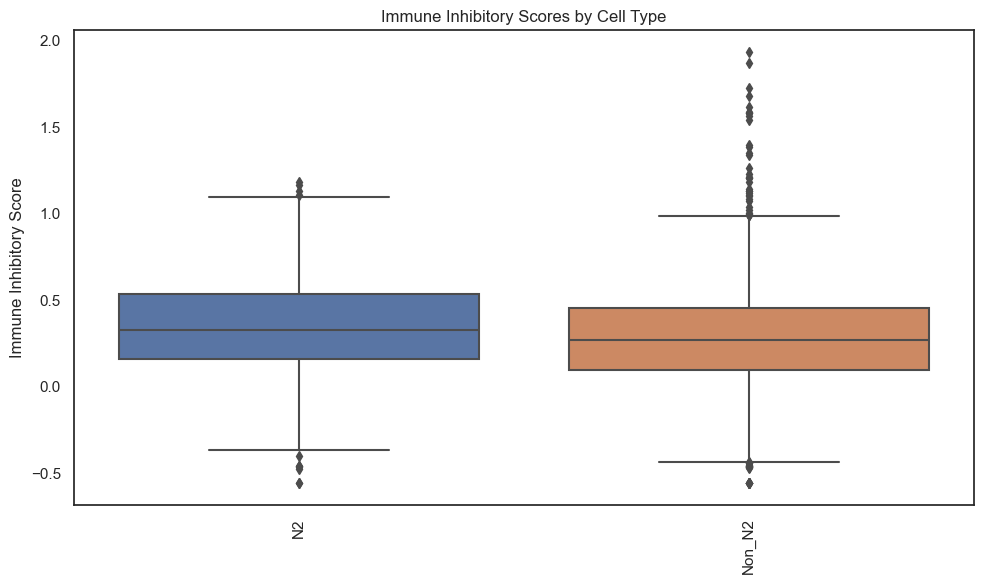

Statistical significance between groups:
P-value between N2 and Non_N2: 2.0557e-07 (significant)

Conclusions:
There is a statistically significant difference in immune inhibitory scores between N2 and Non_N2.


In [36]:
import seaborn as sns
from scipy.stats import mannwhitneyu  

adata = sc.read_h5ad("/share/home/biopharm/wqr/AFPGC/sc/Results/github/Neutrophil_leiden_3cluster.h5ad")

# Load immune inhibitory gene list
immune_gene_path = '/share/home/biopharm/wqr/AFPGC/sc/data/immune_gene2.txt'
with open(immune_gene_path, 'r') as file:
    immune_genes = []
    for line in file:
        immune_genes.extend(line.strip().split(','))

# Filter data to include only immune inhibitory genes
adata_filtered = adata[:, adata.var_names.isin(immune_genes)].copy()

# Calculate average expression of immune inhibitory genes and add to `adata.obs`
adata.obs['metastasis_score'] = adata_filtered.X.mean(axis=1)

# Group by merged cell types
grouped = adata.obs.groupby('leiden_merged')
immune_scores = grouped['metastasis_score'].apply(list)

# Prepare data for boxplot
df_boxplot = pd.DataFrame({group: pd.Series(values) for group, values in immune_scores.items()})

# Calculate median immune inhibitory scores for each cell type
median_scores = df_boxplot.median().sort_values(ascending=False)

# Sort DataFrame columns by median scores
df_boxplot_sorted = df_boxplot[median_scores.index]

# Plot the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_boxplot_sorted)
plt.xticks(rotation=90)
plt.ylabel('Immune Inhibitory Score')
plt.title('Immune Inhibitory Scores by Cell Type')
plt.tight_layout()

plt.savefig('/share/home/biopharm/wqr/AFPGC/sc/Results/github/immune2_boxplot_neutrophil.png')
plt.show()

# Calculate and display statistical significance between groups
p_values = {}
for i, group1 in enumerate(df_boxplot_sorted.columns):
    for j, group2 in enumerate(df_boxplot_sorted.columns):
        if i >= j:
            continue
        _, p_value = mannwhitneyu(df_boxplot_sorted[group1].dropna(), df_boxplot_sorted[group2].dropna())
        p_values[(group1, group2)] = p_value

# Display statistical significance results
significance_level = 0.05
print("Statistical significance between groups:")
for (group1, group2), p_value in p_values.items():
    significance = "significant" if p_value < significance_level else "not significant"
    print(f"P-value between {group1} and {group2}: {p_value:.4e} ({significance})")

print("\nConclusions:")
for (group1, group2), p_value in p_values.items():
    if p_value < significance_level:
        print(f"There is a statistically significant difference in immune inhibitory scores between {group1} and {group2}.")
    else:
        print(f"There is no statistically significant difference in immune inhibitory scores between {group1} and {group2}.")


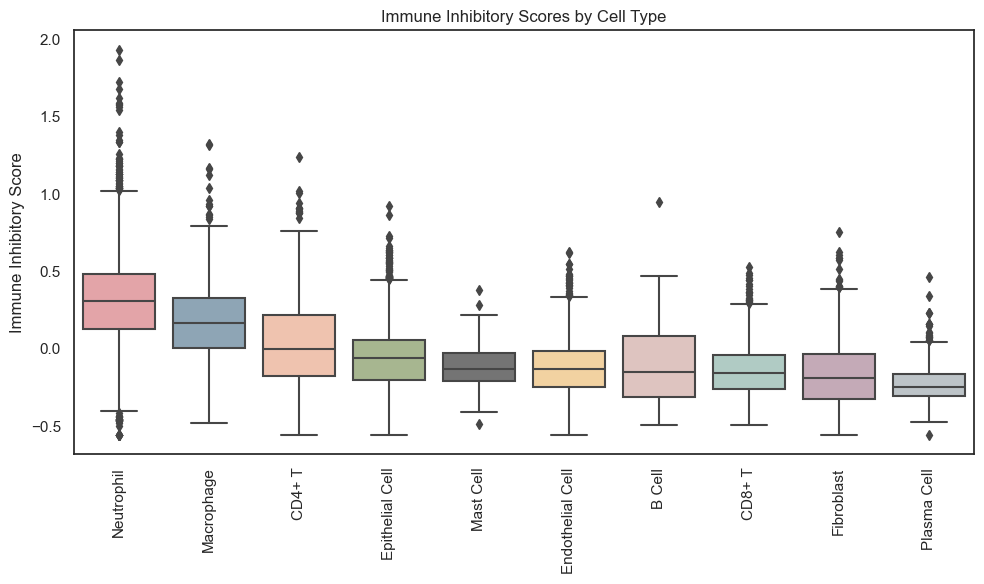

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

adata = sc.read_h5ad("/share/home/biopharm/wqr/AFPGC/sc/Results/github/all_leiden_merged.h5ad")

# Load immune inhibitory gene list
immune_gene_path = '/share/home/biopharm/wqr/AFPGC/sc/data/immune_gene2.txt'
with open(immune_gene_path, 'r') as file:
    immune_genes = []
    for line in file:
        immune_genes.extend(line.strip().split(','))

# Filter data to include only immune inhibitory genes
adata_filtered = adata[:, adata.var_names.isin(immune_genes)].copy()

# Calculate the average expression of immune inhibitory genes and add it to `adata.obs`
adata.obs['metastasis_score'] = adata_filtered.X.mean(axis=1)

# Use the merged cell types
grouped = adata.obs.groupby('leiden_res0_8_merged3')
immune_scores = grouped['metastasis_score'].apply(list)

# Prepare data for box plot
df_boxplot = pd.DataFrame({group: pd.Series(values) for group, values in immune_scores.items()})

# Calculate the median immune inhibitory score for each cell type
median_scores = df_boxplot.median().sort_values(ascending=False)

# Sort DataFrame columns based on median score
df_boxplot_sorted = df_boxplot[median_scores.index]

# Map cell types to colors
cell_type_colors = {
    'Neutrophil': '#EE9A9F',
    'CD4+ T': '#FABFA4',
    'CD8+ T': '#ABCFC6',
    'Macrophage': '#88A6BB',
    'Plasma Cell': '#BBC4CA',
    'B Cell': '#E3C0BB',
    'Mast Cell': '#747474',
    'Epithelial Cell': '#A8BC8A',
    'Endothelial Cell': '#FFD594',
    'Fibroblast': '#C9A5B7'  
}

palette = [cell_type_colors[cell_type] for cell_type in median_scores.index if cell_type in cell_type_colors]

# Customize outlier marker properties
flierprops = dict(marker='d', markersize=5)

# Plot the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_boxplot_sorted, palette=palette, flierprops=flierprops)
plt.xticks(rotation=90)  # Rotate x-axis labels if cell type names are long
plt.ylabel('Immune Inhibitory Score')
plt.title('Immune Inhibitory Scores by Cell Type')
plt.tight_layout()  # Automatically adjust subplot parameters for better fit

plt.savefig('/share/home/biopharm/wqr/AFPGC/sc/Results/github/immune2_boxplot_all.svg')
plt.show()


## Cell Proportion

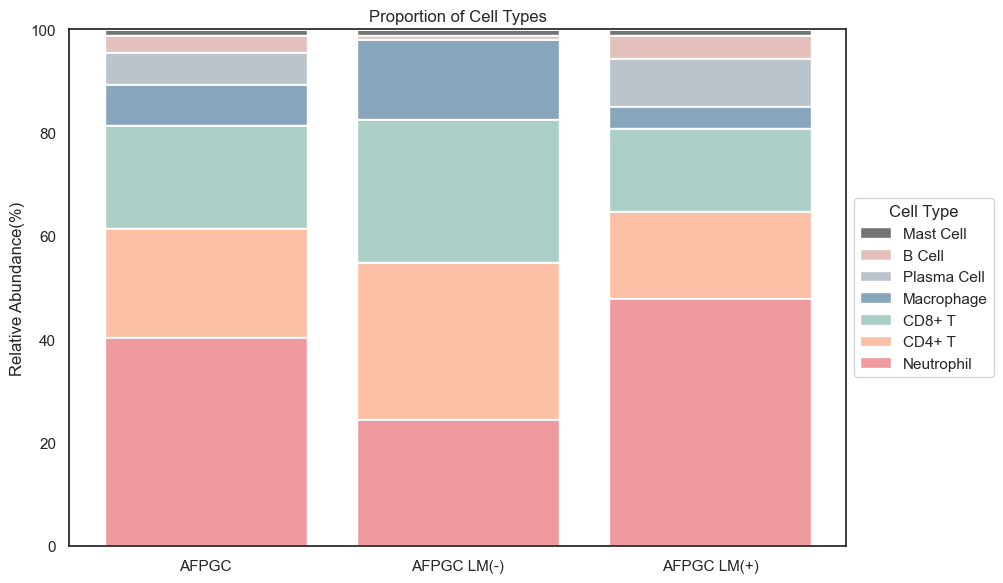

In [41]:
# Read the data
adata = sc.read_h5ad("/share/home/biopharm/wqr/AFPGC/sc/Results/github/all_leiden_merged.h5ad")

# Excluded cell types
exclude_cell_types = ["Endothelial Cell", "Epithelial Cell", "Fibroblast"]

# Filter data to exclude certain cell types and include only the relevant groups
combined_data = adata.obs[~adata.obs['leiden_res0_8_merged3'].isin(exclude_cell_types)]
non_trans_data = combined_data[combined_data['group'] == 'LM_pos']
trans_data = combined_data[combined_data['group'] == 'LM_neg']

# Calculate the proportion of each cell type across all samples, non_met and met groups
combined_counts = combined_data['leiden_res0_8_merged3'].value_counts(normalize=True)
non_trans_counts = non_trans_data['leiden_res0_8_merged3'].value_counts(normalize=True)
trans_counts = trans_data['leiden_res0_8_merged3'].value_counts(normalize=True)

# Sort the proportions in the combined group in descending order and ensure this order is used for all groups
combined_counts.sort_values(ascending=False, inplace=True)
non_trans_counts = non_trans_counts.reindex(combined_counts.index, fill_value=0)
trans_counts = trans_counts.reindex(combined_counts.index, fill_value=0)

# Create and Combine DataFrames
combined_df = pd.DataFrame({'Cell Type': combined_counts.index, 'Proportion': combined_counts.values, 'Group': 'AFPGC'})
non_trans_df = pd.DataFrame({'Cell Type': non_trans_counts.index, 'Proportion': non_trans_counts.values, 'Group': 'AFPGC LM(-)'})
trans_df = pd.DataFrame({'Cell Type': trans_counts.index, 'Proportion': trans_counts.values, 'Group': 'AFPGC LM(+)'})

all_df = pd.concat([combined_df, non_trans_df, trans_df])

# Get unique cell types and sort them by proportion in combined group
cell_types = combined_counts.index

# Define a list of colors for the cell types
cell_colors = ['#EE9A9F','#FABFA4','#ABCFC6','#88A6BB','#BBC4CA','#E3C0BB','#747474','#000000','#000001','#000002']
assert len(cell_colors) >= len(cell_types), "There are not enough colors for the number of cell types."

# Draw the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Initialize a bottom array to represent the starting position for stacking
bottom_array = np.zeros(len(cell_types))

# Stack bar chart for each cell type for the combined group
for cell_type, color in zip(cell_types, cell_colors):
    proportion = combined_df[combined_df['Cell Type'] == cell_type]['Proportion']
    ax.bar('AFPGC', proportion.values[0]*100, label=cell_type, color=color, bottom=bottom_array)
    # Update the bottom position for the next bar
    bottom_array += proportion.values[0]*100

# Plot the other two groups similar to the first one
bottom_dict = {'AFPGC LM(-)': np.zeros(len(cell_types)), 'AFPGC LM(+)': np.zeros(len(cell_types))}

for cell_type, color in zip(cell_types, cell_colors):
    for group, dataframe in zip(['AFPGC LM(-)', 'AFPGC LM(+)'], [non_trans_df, trans_df]):
        proportion = dataframe[dataframe['Cell Type'] == cell_type]['Proportion']
        if not proportion.empty:  # If the current cell type exists in the group
            ax.bar(group, proportion.values[0]*100, color=color, bottom=bottom_dict[group])
            # Update the bottom position for the next bar
            bottom_dict[group] += proportion.values[0]*100


ax.set_ylabel('Relative Abundance(%)')
ax.set_title('Proportion of Cell Types')


handles, labels = ax.get_legend_handles_labels()
handles, labels = zip(*[(h, l) for h, l in zip(handles, labels) if l not in exclude_cell_types])


handles = list(reversed(handles))
labels = list(reversed(labels))

ax.legend(handles, labels, title='Cell Type', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout(rect=[0, 0, 0.85, 1]) 

plt.savefig("/share/home/biopharm/wqr/AFPGC/sc/Results/github/cell_proportion.svg", format='svg', bbox_inches='tight')

plt.show()